### Workflow 

1. Import Relevant Libraries
2. Import Data from Database
3. Data Exploration and Data Cleaning 
4. Exploratory Data Analysis
    - Univariate Analysis 
    - Bi-variate and Multi-variate Analysis 
5. Feature Engineering 



## 1. Import Relevant Libraries

In [2]:
# Import relevant libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## 2. Import Data from Database

In [3]:
# Set up connection to database using sqlite3
conn = sqlite3.connect('data/noshow.db')


In [4]:
# sql query to select all columns from the table noshow
query = "Select * from noshow;"
df = pd.read_sql(query,conn)
#close the connection
conn.close() 

## 3. Data Exploration and Data Cleaning

In [5]:
df.head()

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,1.0,Changi,July,May,19.0,May,20.0,China,Yes,King,None,Email,2,1.0
1,0.0,Orchard,December,February,28.0,March,-4.0,India,Yes,None,USD$ 723.34,Email,1,0.0
2,0.0,Orchard,December,May,22.0,May,24.0,Australia,Yes,Single,SGD$ 650.94,Website,1,0.0
3,0.0,Orchard,October,September,2.0,September,4.0,China,Yes,None,SGD$ 978.67,Agent,1,1.0
4,0.0,Orchard,February,February,7.0,February,8.0,China,Yes,King,None,Website,1,2.0


In [6]:
# Check the data types of the columns, only room and price has null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119391 entries, 0 to 119390
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   no_show         119390 non-null  float64
 1   branch          119390 non-null  object 
 2   booking_month   119390 non-null  object 
 3   arrival_month   119390 non-null  object 
 4   arrival_day     119390 non-null  float64
 5   checkout_month  119390 non-null  object 
 6   checkout_day    119390 non-null  float64
 7   country         119390 non-null  object 
 8   first_time      119390 non-null  object 
 9   room            97778 non-null   object 
 10  price           94509 non-null   object 
 11  platform        119390 non-null  object 
 12  num_adults      119390 non-null  object 
 13  num_children    119390 non-null  float64
dtypes: float64(4), object(10)
memory usage: 12.8+ MB


In [7]:
df.describe()

,no_show,arrival_day,checkout_day,num_children
count,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,15.798241,14.250507,0.871229
std,0.482918,8.780829,11.063697,0.779796
min,0.000000,1.000000,-31.000000,0.000000
25%,0.000000,8.000000,7.000000,0.000000
50%,0.000000,16.000000,15.000000,1.000000
75%,1.000000,23.000000,23.000000,1.000000
max,1.000000,31.000000,31.000000,3.000000


<AxesSubplot:title={'center':'Unique values per feature'}>

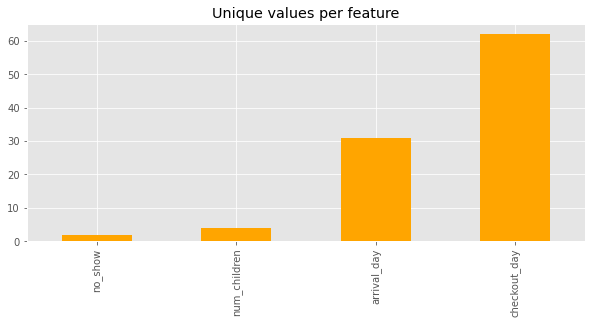

In [8]:
# Find out the number of unique values of the categorical features 
unique_values_cat = df.select_dtypes(
  include= "object").nunique().sort_values()

# Find out the number of unique values of the numerical features 
unique_values_con = df.select_dtypes(
  include= "number").nunique().sort_values()

# Plot a countplot of the unique values per numerical feature
unique_values_con.plot.bar(logy=False, figsize=(10, 4),
                       title="Unique values per feature", color= 'orange')

<AxesSubplot:title={'center':'Unique values per feature'}>

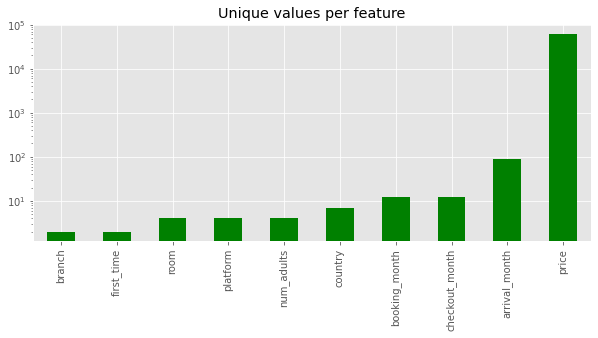

In [9]:
# Plot a countplot of the unique values per categorical feature
unique_values_cat.plot.bar( figsize=(10, 4),
                       title="Unique values per feature", color= 'green', logy=True)

Based on the plots above, some of the columns have wrong data types e.g price should be a continuous feature and not categorical. The continuous features in the first plot should be converted to categorical features instead. Therefore, data cleaning is needed. 


In [10]:
# Check the values of each column and their distribution
for i in df.columns:
    print(df[i].value_counts())

0.0    75166
1.0    44224
Name: no_show, dtype: int64
Changi     79330
Orchard    40060
Name: branch, dtype: int64
June         10324
September    10315
November     10280
January      10214
August       10134
October      10068
July          9993
March         9754
February      9588
May           9588
April         9571
December      9561
Name: booking_month, dtype: int64
August      13695
July        12515
May         11684
October     11009
April       10966
            ...  
FeBruaRy        1
MAY             1
FeBruarY        1
ApRiL           1
DecEMber        1
Name: arrival_month, Length: 88, dtype: int64
17.0    4406
5.0     4317
15.0    4196
25.0    4160
26.0    4147
9.0     4096
12.0    4087
16.0    4078
2.0     4055
19.0    4052
20.0    4032
18.0    4002
24.0    3993
28.0    3946
8.0     3921
3.0     3855
30.0    3853
6.0     3833
14.0    3819
27.0    3802
21.0    3767
4.0     3763
13.0    3745
7.0     3665
1.0     3626
23.0    3616
11.0    3599
22.0    3596
29.0    3580
10

Observations for each column: 

1. no_show - convert to datatype integer 
2. branch - dummy encoding can be done
3. Booking month - frequency encoding can be done
4. Arrival month - The labels are all in mixture of upper and lowercase, therefore there is a need to clean up. Frequency encoding can be done. 
5. arrival day - frequency encoding can be done
6. check out month - frequency encoding can be done
7. check out day - The labels have negative values , which is not logical for a day date format, thus need to clean up. Frequency encoding can be done
8. country - dummy encoding can be done 
9. first time - dummy encoding can be done
10. room type - Misisng values are present , will need to fill in missing values with mode and dummy encoding can be done
11. price - Will need to clean up and standardised to SGD currency , fill in missing with mean and check if it is normally distributed and need log transformation
12. platform - dummy encoding cna be done
13. num_adults - will need to clean up as the labels are not standardised and dummy encoding can be done
14. num_children - will need to chnage datatype to int and dummy encoding can be done

#### Dealing with null values and imputing missing values

<AxesSubplot:>

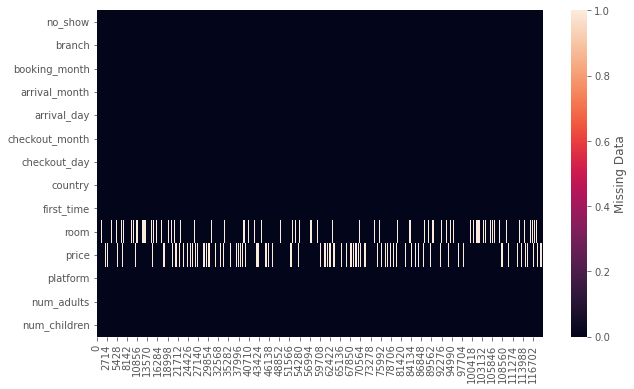

In [11]:
# Visualise null values using heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose(),
            cbar_kws={'label': 'Missing Data'})

In [12]:
# Check for null values in the dataframe
df.isnull().sum()

no_show               1
branch                1
booking_month         1
arrival_month         1
arrival_day           1
checkout_month        1
checkout_day          1
country               1
first_time            1
room              21613
price             24882
platform              1
num_adults            1
num_children          1
dtype: int64

In [13]:
# As most of the columns seem to have only 1 null value, it could be from the same row, check row number for null value of no_show
df.loc[df['no_show'].isnull(),'no_show']

115536   NaN
Name: no_show, dtype: float64

In [14]:
# Investigate row 115536
df.iloc[115536]

no_show            NaN
branch            None
booking_month     None
arrival_month     None
arrival_day        NaN
checkout_month    None
checkout_day       NaN
country           None
first_time        None
room              None
price             None
platform          None
num_adults        None
num_children       NaN
Name: 115536, dtype: object

In [15]:
# Indeed, all the null value comes from row 115536, hence this row shall be removed
df.drop(115536, axis = 0, inplace = True)
# Reset index of the dataset after dropping row
df.reset_index(drop= True, inplace = True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   no_show         119390 non-null  float64
 1   branch          119390 non-null  object 
 2   booking_month   119390 non-null  object 
 3   arrival_month   119390 non-null  object 
 4   arrival_day     119390 non-null  float64
 5   checkout_month  119390 non-null  object 
 6   checkout_day    119390 non-null  float64
 7   country         119390 non-null  object 
 8   first_time      119390 non-null  object 
 9   room            97778 non-null   object 
 10  price           94509 non-null   object 
 11  platform        119390 non-null  object 
 12  num_adults      119390 non-null  object 
 13  num_children    119390 non-null  float64
dtypes: float64(4), object(10)
memory usage: 12.8+ MB


Only Room and Price columns have missing values. Therefore, the missing values will be replaced by mode for Room and mean for Price. 

In [17]:
# Finding out the percentage of missing values for Room and price 
print('% of missing values in room:', (df['room'].isnull().sum()/len(df))*100)
print('% of missing values in price:', (df['price'].isnull().sum()/len(df))*100)

% of missing values in room: 18.102018594522153
% of missing values in price: 20.840103861294914


In [18]:
# Fill in missing values for room column using Mode
df['room'] = df['room'].fillna(df['room'].mode()[0])

In [19]:
# Replace all null values with SGD$ 0 for price column 
df.loc[df['price'].isnull(), 'price'] = 'SGD$ 0'

In [20]:
# Clean up price column - do currency conversion and remove all the dollar signs and commas
# Using usd $1 = sgd $1.39 accurate as of 16th June 2022

def price_convert (x):
    if x is not np.nan:
        x = str(x).split('$')
        if x[0] == 'USD':
            x[1] = float(x[1])*1.39
        else:
            x[1] = float(x[1])
    
    return x[1]

In [21]:
# Apply function to standardise the price in SGD for price column 
df['price'] = df['price'].apply(price_convert)

In [22]:
# Replace price = 0.00 with mean for price column 
df.loc[df['price'] == 0, 'price'] = df['price'].mean()

In [23]:
# Check if there are any more null values in the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   no_show         119390 non-null  float64
 1   branch          119390 non-null  object 
 2   booking_month   119390 non-null  object 
 3   arrival_month   119390 non-null  object 
 4   arrival_day     119390 non-null  float64
 5   checkout_month  119390 non-null  object 
 6   checkout_day    119390 non-null  float64
 7   country         119390 non-null  object 
 8   first_time      119390 non-null  object 
 9   room            119390 non-null  object 
 10  price           119390 non-null  float64
 11  platform        119390 non-null  object 
 12  num_adults      119390 non-null  object 
 13  num_children    119390 non-null  float64
dtypes: float64(5), object(9)
memory usage: 12.8+ MB


#### Check for duplicates 

In [24]:
duplicate = df[df.duplicated()]
duplicate

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
6397,0.0,Orchard,December,February,12.0,February,14.0,China,Yes,Single,756.830346,Email,1,1.0
7734,1.0,Changi,June,April,28.0,May,1.0,China,Yes,King,756.830346,Website,2,2.0
8497,1.0,Changi,October,March,25.0,March,26.0,China,Yes,King,756.830346,Website,1,0.0
9378,1.0,Changi,May,August,14.0,August,16.0,China,Yes,King,756.830346,Website,1,2.0
10080,0.0,Orchard,May,July,21.0,July,23.0,Japan,Yes,Single,756.830346,Website,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118719,1.0,Changi,November,June,5.0,June,7.0,China,Yes,King,756.830346,Website,2,0.0
119229,1.0,Changi,August,May,19.0,May,21.0,China,Yes,King,756.830346,Website,2,2.0
119275,0.0,Changi,February,August,22.0,August,24.0,Malaysia,Yes,King,756.830346,Website,1,1.0
119317,0.0,Orchard,July,August,16.0,August,17.0,China,Yes,King,756.830346,Email,1,2.0


In [25]:
# Remove duplicates 
df.drop_duplicates(keep= 'first', inplace = True)

In [26]:
# Reset index of the dataset after dropping row
df.reset_index(drop= True, inplace = True)

In [27]:
# Double check if data is properly cleaned - with no null values and duplicates removed 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118576 entries, 0 to 118575
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   no_show         118576 non-null  float64
 1   branch          118576 non-null  object 
 2   booking_month   118576 non-null  object 
 3   arrival_month   118576 non-null  object 
 4   arrival_day     118576 non-null  float64
 5   checkout_month  118576 non-null  object 
 6   checkout_day    118576 non-null  float64
 7   country         118576 non-null  object 
 8   first_time      118576 non-null  object 
 9   room            118576 non-null  object 
 10  price           118576 non-null  float64
 11  platform        118576 non-null  object 
 12  num_adults      118576 non-null  object 
 13  num_children    118576 non-null  float64
dtypes: float64(5), object(9)
memory usage: 12.7+ MB


## Data Cleaning for each columns (when necessary)

#### 1. no_show

In [28]:
# Change datatype to integer
df['no_show'] = df['no_show'].astype(int)


#### 2. booking_month

In [29]:
# Create custom ordering for the column booking_month
df['booking_month'] = df['booking_month'].str.lower()
list_ordering1 = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']  
df["booking_month"] = pd.Categorical(df["booking_month"], categories=list_ordering1) 

#### 3. arrival_month

In [30]:
df['arrival_month'].unique()

array(['May', 'February', 'September', 'April', 'SepTember', 'March',
       'June', 'January', 'July', 'October', 'December', 'November',
       'August', 'AprIl', 'JulY', 'DecemBer', 'SEptember', 'FebruaRy',
       'MarCh', 'JuNe', 'MAy', 'OCtober', 'OctOber', 'ApriL', 'NovEmber',
       'NOvember', 'DEcember', 'SeptembeR', 'AugusT', 'JUly', 'JunE',
       'MaY', 'NovembEr', 'FeBruary', 'ApRil', 'JuLy', 'NoVember',
       'OcTober', 'SeptembEr', 'OctoBer', 'DecembeR', 'JUne', 'FEbruary',
       'APril', 'DecembEr', 'MarcH', 'JanuarY', 'AuGust', 'MArch',
       'SePtember', 'JanUary', 'AUgust', 'AuguSt', 'AugUst', 'MaRch',
       'SeptEMber', 'FebrUary', 'FebruarY', 'DeceMber', 'OctobeR',
       'NovemBer', 'SepteMber', 'JanuAry', 'OctobEr', 'JanuaRy',
       'JaNuary', 'ApRiL', 'FeBruarY', 'FebRuary', 'JAnuary', 'FebruAry',
       'SeptemBer', 'SeptEmber', 'NoveMber', 'DecEmber', 'DeCember',
       'MAY', 'NovembeR', 'FeBruaRy', 'FebruaRY', 'JUnE', 'OCTober',
       'NOveMber', 'Nove

In [31]:
# Convert all the months to lowercase 
df['arrival_month'] = df['arrival_month'].str.lower()

In [32]:
df['arrival_month'].unique()

array(['may', 'february', 'september', 'april', 'march', 'june',
       'january', 'july', 'october', 'december', 'november', 'august'],
      dtype=object)

In [33]:
# Create custom ordering for the column arrival_month
df["arrival_month"] = pd.Categorical(df["arrival_month"], categories=list_ordering1) 

#### 4. arrival_day

In [34]:
# Convert datatype to integer 
df['arrival_day'] = df['arrival_day'].astype(int)

In [35]:
# Convert datatype to str 
df['arrival_day'] = df['arrival_day'].astype(str)

In [36]:
df['arrival_day'].unique()

array(['19', '28', '22', '2', '7', '17', '4', '31', '14', '20', '24',
       '15', '23', '25', '16', '12', '18', '27', '11', '1', '8', '6',
       '30', '3', '10', '26', '13', '5', '21', '29', '9'], dtype=object)

In [37]:
#Create custom ordering for the column arrival_day
list_ordering2 = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
df["arrival_day"] = pd.Categorical(df["arrival_day"], categories=list_ordering2)

#### 5. check_out_month

In [38]:
df['checkout_month'].unique()

array(['May', 'March', 'September', 'February', 'April', 'June',
       'January', 'July', 'October', 'December', 'November', 'August'],
      dtype=object)

In [39]:
# Convert all the months to lowercase 
df['checkout_month'] = df['checkout_month'].str.lower()

In [40]:
df["checkout_month"] = pd.Categorical(df["checkout_month"], categories=list_ordering1) 

#### 6. checkout_day

In [41]:
# Mod all values to remove the minus sign as it might be due to typo 
df['checkout_day'] = df['checkout_day'].abs()

In [42]:
df['checkout_day'].unique()

array([20.,  4., 24.,  8., 19.,  6.,  2., 17., 22., 26.,  9.,  1., 15.,
        3., 27., 18., 13., 29.,  5., 25., 10.,  7., 16., 30., 31., 11.,
       28., 23., 14., 12., 21.])

In [43]:
df['checkout_day'] = df['checkout_day'].astype(int)
df['checkout_day'] = df['checkout_day'].astype(str)

In [44]:
#Create custom ordering for the column checkout_day
df["checkout_day"] = pd.Categorical(df["checkout_day"], categories=list_ordering2)

#### 7. num_adults

In [45]:
df['num_adults'].unique()

array(['2', '1', 'one', 'two'], dtype=object)

In [46]:
df.loc[df['num_adults']== 'one', 'num_adults'] = 1

In [47]:
df.loc[df['num_adults']== 'two', 'num_adults'] = 2

In [48]:
# Convert datatype to str
df['num_adults'] = df['num_adults'].astype(str)

In [49]:
# Create custom ordering for the column num_adults
list_ordering3 = ['1', '2']
df["num_adults"] = pd.Categorical(df["num_adults"], categories=list_ordering3)

#### 8. num_children

In [50]:
# Convert datatype to string
df['num_children'] = df['num_children'].astype(int)
df['num_children'] = df['num_children'].astype(str)

In [51]:
# Create custom ordering for the column num_children
list_ordering4 = ['0', '1', '2', '3']
df["num_children"] = pd.Categorical(df["num_children"], categories=list_ordering4)

In [52]:
df['num_children'].value_counts()

1    45275
0    44446
2    28607
3      248
Name: num_children, dtype: int64

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118576 entries, 0 to 118575
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   no_show         118576 non-null  int32   
 1   branch          118576 non-null  object  
 2   booking_month   118576 non-null  category
 3   arrival_month   118576 non-null  category
 4   arrival_day     118576 non-null  category
 5   checkout_month  118576 non-null  category
 6   checkout_day    118576 non-null  category
 7   country         118576 non-null  object  
 8   first_time      118576 non-null  object  
 9   room            118576 non-null  object  
 10  price           118576 non-null  float64 
 11  platform        118576 non-null  object  
 12  num_adults      118576 non-null  category
 13  num_children    118576 non-null  category
dtypes: category(7), float64(1), int32(1), object(5)
memory usage: 6.7+ MB


## 4. Exploratory Data Analysis

#### a. Univariate Analysis

In this section, it will address the question of how the various features vary with the outcome of no show and provide an overview of how the features interact with the outcome.
In order to get meaningful results, a sub-dataset containing only the no show cases will be created and used for analysis.

In [54]:
noshows = df.loc[df['no_show'] == 1] 

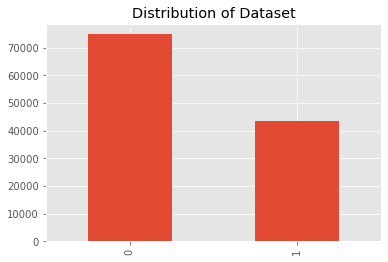

0    74875
1    43701
Name: no_show, dtype: int64
weights 1.7133475206517013


In [67]:
# Check for class distribution 
df['no_show'].value_counts().plot(kind="bar")
plt.title("Distribution of Dataset")
plt.show()
print(df['no_show'].value_counts())
print('weights',df['no_show'].value_counts()[0]/df['no_show'].value_counts()[1])

As seen from the above plot, the dataset is moderately imbalanced with occurences of label 0 being 1.71 times more than the occurences of label 1. This issue will be addressed during the machine learning section. 

1. Continuous feature - Price

Text(0.5, 1.0, 'Distribution of Room Prices')

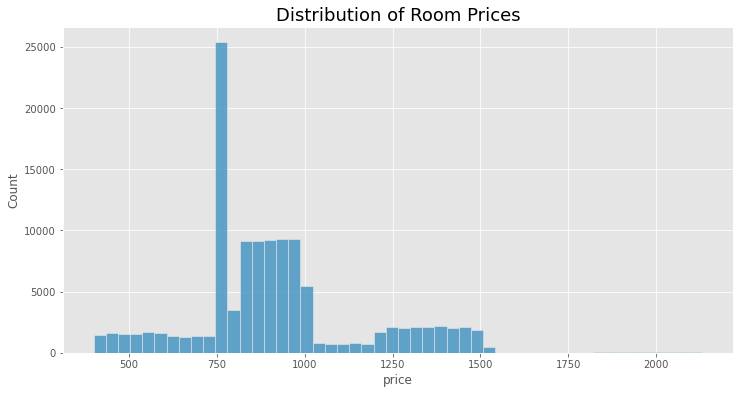

In [55]:
plt.figure(figsize = (12, 6))
sns.histplot(x = 'price', data = df, palette = 'Set2', bins = 50).set_title('Distribution of Room Prices', fontsize = 18)
#plt.xticks(rotation=90, fontsize = 12)

Text(0.5, 1.0, 'Distribution of Room Prices')

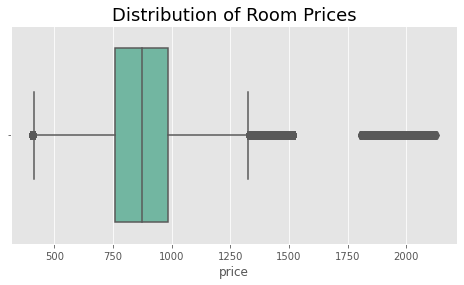

In [56]:
plt.figure(figsize = (8,4))
sns.boxplot(x = 'price', data = df, palette = 'Set2').set_title('Distribution of Room Prices', fontsize = 18)

In [57]:
# Find out the % of outliers in the dataset 
print('% of price outliers:', (len(df.loc[df['price']> 1250, 'price'])/len(df))*100)

% of price outliers: 14.00452030765079


As seen from the boxplot above, there are quite a substantial number of outliers (14%) in the price column. However, as hotel room prices can fluctuate during different seasons of the year ( e.g holidays and high demand), the high prices could be logical and a reflection of the reality. Therefore, we will not remove the outliers. Instead, log transformation will be applied later to the price column to see if it helps to make the price be normally distributed.

Text(0.5, 1.0, 'Distribution of Room Prices for No Show Cases')

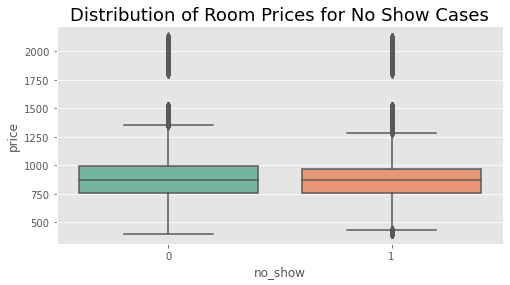

In [59]:
# Plotting boxplot for no show cases
plt.figure(figsize = (8, 4))
sns.boxplot(y = 'price', x = 'no_show', data = df, palette = 'Set2').set_title('Distribution of Room Prices for No Show Cases', fontsize = 18)

The price distribution for no show is similar to the overall distribution and the average price of the room is around $875. 

2. Categorical features

In [410]:
# Sieve out all categorical features based on the number of unique values
categorical = []
for col in df.columns: 
    if df[col].nunique() < 100:
        categorical.append(col)
categorical

['no_show',
 'branch',
 'booking_month',
 'arrival_month',
 'arrival_day',
 'checkout_month',
 'checkout_day',
 'country',
 'first_time',
 'room',
 'platform',
 'num_adults',
 'num_children']

Exploring how the categorical features vary for no show cases

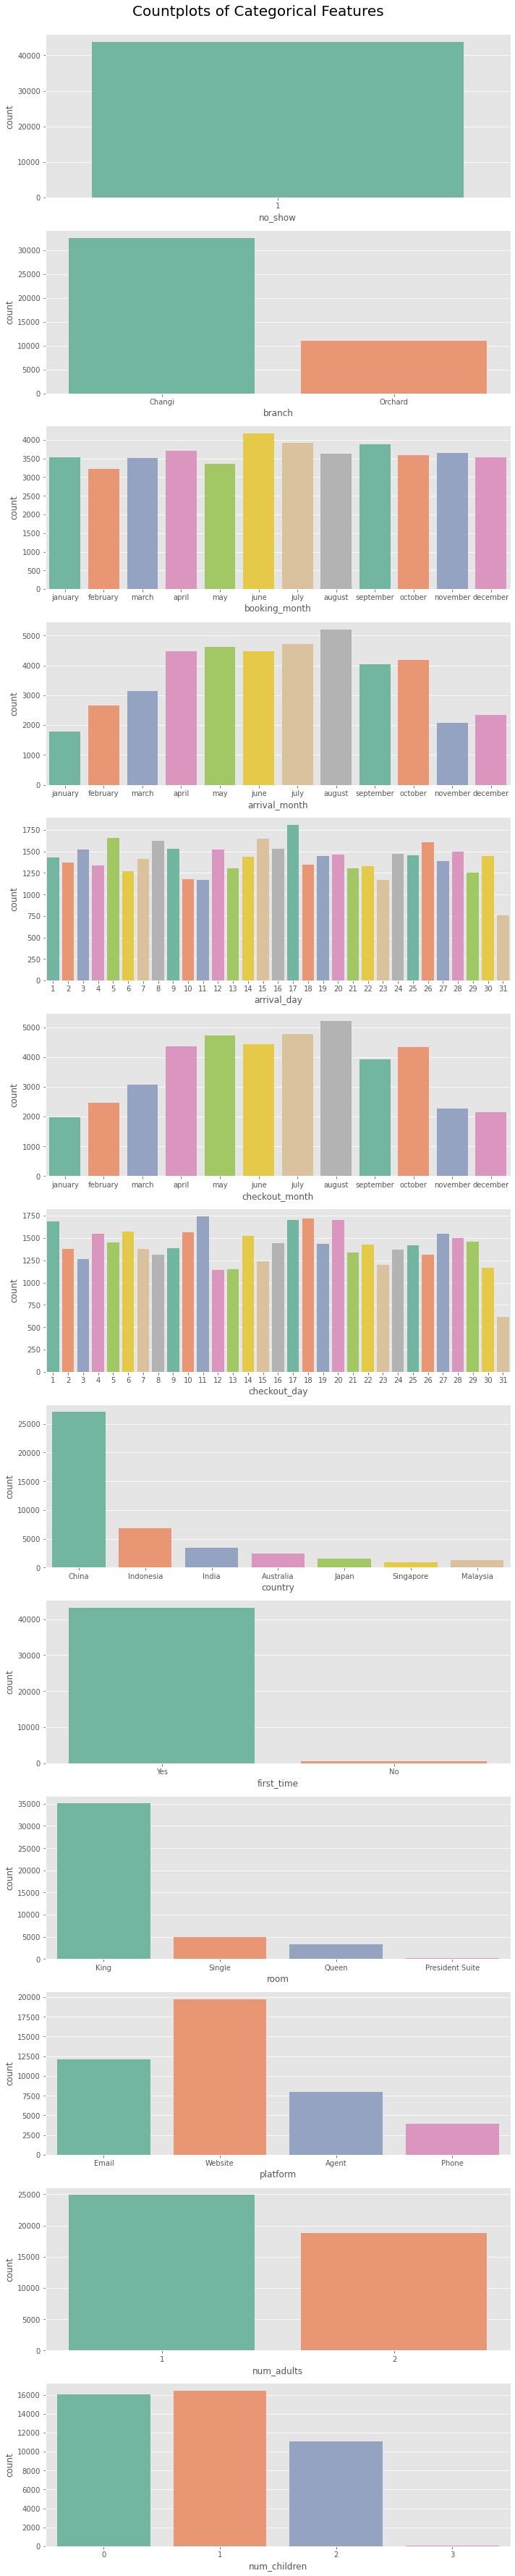

In [411]:
# Create a For loop to visualise countplots for all categorical features
n=len(categorical)
fig,ax = plt.subplots(n ,1, figsize=(10,n*4))

for i in range(n):
    plt.sca(ax[i])  #Set the current Axes to ax and the current Figure to the parent of ax
    col = categorical[i]
    sns.countplot(x=col, data= noshows, palette = 'Set2')
    
    fig.suptitle ('Countplots of Categorical Features', fontsize = 20)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])

From the plots above, there are several interesting trends that can be observed. 
1. Majority of the no show cases are from Changi hotel branch.
2. No shows are slightly higher in booking months of June, July and September
3. No shows are the highest during the arrival months of May to August and this seems to be in line with the summer season of the year.
4. No shows mainly falls within checkout months of April to October.
5. A significant number of no shows were visitors from China. 
6. Large majority of no shows are from visitors who booked the room at the hotel for the first time and from those who booked a king sized room 
7. Most of the no shows are from visitors who booked a room through websites or emails. Perhaps websites and emails are the most convenient way to book a hotel room and there are a large number of bookings through websites and emails, thus the no show rate through thes eplatforms might be higher as well. 
8. No shows tend to be slightly higher for 1 adult and those with 0 or 1 child.


Insights: 
- It seems like there are more no show cases in the summer months such as May-August, irregardless of whether it is a booking month, arrival month or checkout month. These might be a period where it is the travelling peak during the summer holidays. Higher rates of booking/arrival/checkouts during this period may also naturally lead to higher probability of getting no show cases. 

- Most of the no show cases come from Changi Branch and there might be a few reasons which influence the no show rate.
    - The appeal of Changi branch might not be as strong, thus vistors who subsequently found better hotels might not be interested. 
    - Changi branch might impose lesser penalties/ less strict in cancellation and no show policies.
    - Exploration on the difference between these two branches can explored further in the next section. 


- Hypothesis - The lower the room price is , the higher the tendency for vistors to do a no show
    - Since most of the no shows are from visitors who booked a room through websites or emails, more can be explored on whether hotel prices differs between these platforms and cheaper hotel rooms might make it easier for visitors to forego the room and do a no show.

    - Since a large majority of no shows come from China, it might be a good idea to explore the differences in the room prices across countries to see if prices do affect the number of no shows. 

    - It will also be interesting to see how prices vary across room types. Logically, king-sized rooms are more expensive, but the no show cases for king sized rooms are the highest. 

    - How does price vary for a person who booked the first time and a person who booked a room multiple times? 

#### (b) Bi-variate and Multi-variate Analysis

In this section, it will address the exploration areas uncovered by the univariate analysis. 
The hypothesis in which the analysis will based on: 
    - The lower the room price is , the higher the tendency for vistors to do a no show

Some guiding questions uncovered from the insights of univariate analysis:

1. Do the price differ for Changi and Orchard branch? 

2. Since most of the no shows are from visitors who booked a room through websites or emails, more can be explored on whether hotel prices differs between these platforms and cheaper hotel rooms might make it easier for visitors to forego the room and do a no show.

3. Since a large majority of no shows come from China, it might be a good idea to explore the differences in the room prices across countries to see if prices do affect the number of no shows. 

4. It will also be interesting to see how prices vary across room types. Logically, king-sized rooms are more expensive, but the no show cases for king sized rooms are the highest. 

5. How does price vary for a person who booked the first time and a person who booked a room multiple times? 



1. Do the price differ for Changi and Orchard branch? 

Text(0.5, 1.0, 'Distribution of Room Prices for No Show Cases across Branches')

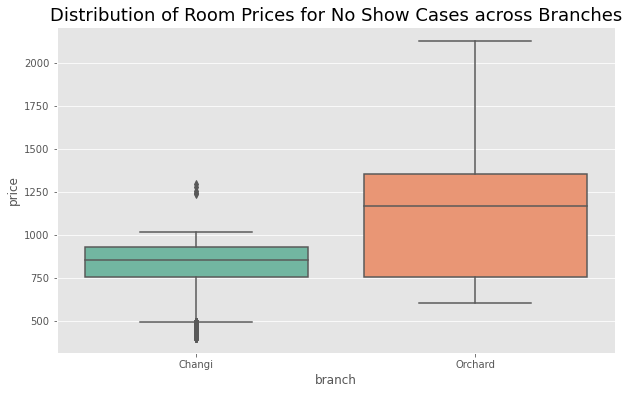

In [412]:
 #Plotting boxplots for price for no show cases across branches
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'branch', y = 'price', data = noshows, palette = 'Set2').set_title('Distribution of Room Prices for No Show Cases across Branches', fontsize = 18)

Indeed, the room prices for Changi is so much lower than the orchard branch. The low price might make it easier for visitors to forego the room and do a no show. It could also be due to the location of the hotel, as the changi branch not located in the city center, thus making it less appealing and convenient compared to the Orchard branch. This might affect the decision of the visitors to do a no show as well. 

In [413]:
# filter out rows for Changi branch only
changi = noshows.loc[noshows['branch'] == 'Changi']
changi.head()

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,1,Changi,july,may,19,may,20,China,Yes,King,756.830346,Email,2,1
7,1,Changi,december,march,31,april,2,China,Yes,King,924.892100,Website,2,0
8,1,Changi,july,june,14,june,17,China,Yes,King,973.319700,Website,1,2
12,1,Changi,january,september,22,september,24,China,Yes,King,859.110000,Email,2,2
13,1,Changi,august,july,2,july,4,Indonesia,Yes,King,874.615800,Agent,2,0


Next, we explore the differences in the room prices across countries to see if prices do affect the number of no shows. Since China has the most number of no show cases, we should expect the prices to be the lowest across countries.

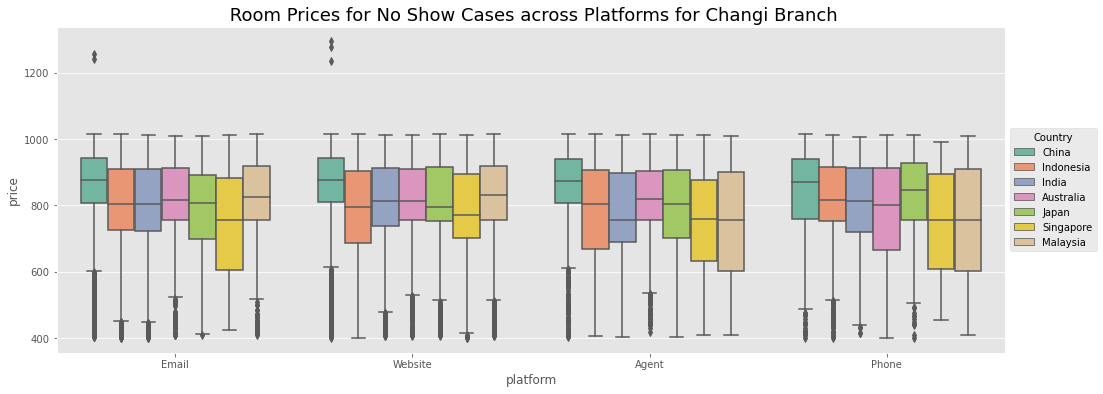

In [414]:
# Find out how noshow visitors are booking rooms in Changi branch

plt.figure(figsize = (17, 6))
sns.boxplot(x = 'platform', y = 'price', data = changi, palette = 'Set2', hue = 'country').set_title(' Room Prices for No Show Cases across Platforms for Changi Branch', fontsize = 18)
plt.legend(title = 'Country', loc='center left', bbox_to_anchor=(1, 0.5))

It is quite interesting to note that prices for Changi branch are quite consistent across platforms and countries except China. Prices for visitors from China are higher compared to other countries. This deviates from the hypothesis that lower room prices will lead to higher no show cases. In this case, China had the highest room prices but yet the no show cases are the highest.

Addressing the following questions:

2. Since most of the no shows are from visitors who booked a room through websites or emails, more can be explored on whether hotel prices differs between these platforms. 
3. It will also be interesting to see how prices vary across room types. Logically, king-sized rooms are more expensive, but the no show cases for king sized rooms are the highest. 

Text(0.5, 1.0, 'Distribution of Room Prices for No Show Cases across Room Types')

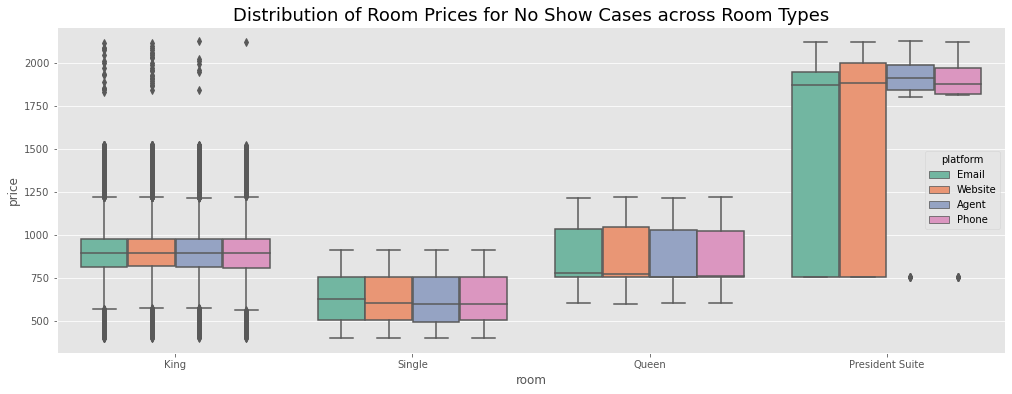

In [415]:
plt.figure(figsize = (17, 6))
sns.boxplot(x = 'room', y = 'price', data = noshows, palette = 'Set2', hue = 'platform').set_title('Distribution of Room Prices for No Show Cases across Room Types', fontsize = 18)

Again, room prices across room types are consistent across platforms. However, although the room prices for president suite and king rooms are much higher, the no show cases for king sized rooms are significantly higher. This indicates that the room prices might not be a major influence on the no show cases

5. How does price vary for a person who booked the first time and a person who booked a room multiple times? 

Text(0.5, 1.0, 'Average Room Price for First Time and Repeated Guests in No Show Cases')

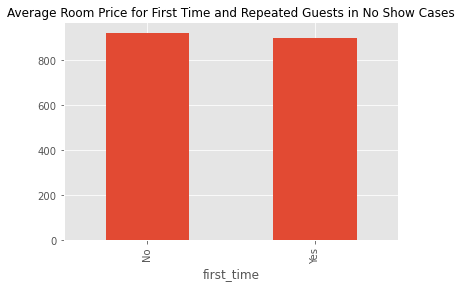

In [416]:
# Finding out the average room price for first time guests and repeated guests 
noshows.groupby('first_time')['price'].mean().plot(kind = 'bar')
plt.title('Average Room Price for First Time and Repeated Guests in No Show Cases', fontsize = 12)

The average room prices did not differ much from each other for first time and repeated guests. Therefore, price does not really play a major influence on whether visitors decide to do a no show case. 

### Conclusion 

The hypothesis that lower room prices will lead to higher number of no show cases does not hold in this preliminary EDA. There might be several other factors that influence the no show cases. Some possible factors might be:

1. Hotel might not be as appealing compared to other hotels. For example, the Changi branch's location is not great and people might change their mind and choose to book other hotels which have better location. 

2. The hotel might not have a strict no show or cancellation policy, which allows people to do a no show without being penalised heavily. As this affects the revenue of the hotel, the hotel should take this seriously and look into how the policies can be improved and deter more peopple from doing a no show. 

3. No show cases can be seasonal and more liekly to occur during the summer months, where demand for hotels can be higher due to summer holidays. With an increase in demand and booking, the hotel will also experience higher no show cases. 

4. It is interesting that most of the no shows come from visitors from china and first time guests. Perhaps the hotel should really look at their appeal to potential customers or customers from China especially. 


## 5. Feature Engineering

This section will perform necessary feature engineering for the features. As most of the features are categorical, encoding will need to be performed to convert the categorical features into numerical features to prepare the data for machine learning.  

1. no_show - No encoding needed as it is already in numerical format 
2. branch - dummy encoding 
3. Booking month - frequency encoding 
4. Arrival month - frequency encoding 
5. arrival day - frequency encoding 
6. check out month - frequency encoding
7. check out day - frequency encoding 
8. country - dummy encoding  
9. first time - dummy encoding 
10. room type - dummy encoding 
11. price -  Might need log transformation to take care of outliers and make it normally distributed 
12. platform - dummy encoding
13. num_adults - dummy encoding
14. num_children - dummy encoding 

In [417]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118576 entries, 0 to 118575
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   no_show         118576 non-null  int32   
 1   branch          118576 non-null  object  
 2   booking_month   118576 non-null  category
 3   arrival_month   118576 non-null  category
 4   arrival_day     118576 non-null  category
 5   checkout_month  118576 non-null  category
 6   checkout_day    118576 non-null  category
 7   country         118576 non-null  object  
 8   first_time      118576 non-null  object  
 9   room            118576 non-null  object  
 10  price           118576 non-null  float64 
 11  platform        118576 non-null  object  
 12  num_adults      118576 non-null  category
 13  num_children    118576 non-null  category
dtypes: category(7), float64(1), int32(1), object(5)
memory usage: 6.7+ MB


### (a) Get Dummies Encoding

In [418]:
# Define the list of columns to do get dummies encoding 
dummies= ['branch', 'country', 'first_time', 'room', 'platform', 'num_adults', 'num_children']

In [419]:
dum = pd.get_dummies(df[dummies], drop_first=True, dtype= 'int64')
dum

,branch_Orchard,country_China,country_India,country_Indonesia,country_Japan,country_Malaysia,country_Singapore,first_time_Yes,room_President Suite,room_Queen,room_Single,platform_Email,platform_Phone,platform_Website,num_adults_2,num_children_1,num_children_2,num_children_3
0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0
1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0
3,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118571,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0
118572,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
118573,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
118574,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0


In [420]:
# merge the dummies back to the original dataframe
df1= pd.concat([df, dum], axis = 1)

In [421]:
# drop the columns that are not required anymore
df1.drop(dummies,axis = 1, inplace = True)

In [422]:
df1.head()

,no_show,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,price,branch_Orchard,country_China,country_India,...,room_President Suite,room_Queen,room_Single,platform_Email,platform_Phone,platform_Website,num_adults_2,num_children_1,num_children_2,num_children_3
0,1,july,may,19,may,20,756.830346,0,1,0,...,0,0,0,1,0,0,1,1,0,0
1,0,december,february,28,march,4,1005.442600,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2,0,december,may,22,may,24,650.940000,1,0,0,...,0,0,1,0,0,1,0,0,0,0
3,0,october,september,2,september,4,978.670000,1,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0,february,february,7,february,8,756.830346,1,1,0,...,0,0,0,0,0,1,0,0,1,0


### (b) Frequency Encoding

In [423]:
# Create a list containing the columns to do frequency encoding 
freqlist = ['booking_month', 'arrival_month', 'arrival_day', 'checkout_month', 'checkout_day']

In [424]:
#Create a function to calculate frequency for each category in the columns under freqlist and do frequency encoding for each column  
df_fe = pd.DataFrame()
def freqenc (freqlist, df):
    for i in freqlist:
        counts = df[i].value_counts()
    # get frequency of each category
        encoding = counts/len(df)
    # map() maps the frequency of each category to each observation
        df_fe[i] = df[i].map(encoding)
        df_fe[i] = df_fe[i].astype(float)
    df.drop(freqlist, axis = 1, inplace = True)  # Drop original columns 
    # Concat the results to the original dataframe 
    df= pd.concat([df, df_fe], axis = 1)
    
    return(df)

In [425]:
df1 = freqenc(freqlist, df1)

In [426]:
df1

,no_show,price,branch_Orchard,country_China,country_India,country_Indonesia,country_Japan,country_Malaysia,country_Singapore,first_time_Yes,...,platform_Website,num_adults_2,num_children_1,num_children_2,num_children_3,booking_month,arrival_month,arrival_day,checkout_month,checkout_day
0,1,756.830346,0,1,0,0,0,0,0,1,...,0,1,1,0,0,0.083643,0.098713,0.033885,0.100821,0.037031
1,0,1005.442600,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0.080067,0.067459,0.033067,0.079814,0.034940
2,0,650.940000,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0.080067,0.098713,0.030149,0.100821,0.030757
3,0,978.670000,1,1,0,0,0,0,0,1,...,0,0,1,0,0,0.084275,0.087615,0.034012,0.086889,0.034940
4,0,756.830346,1,1,0,0,0,0,0,1,...,1,0,0,1,0,0.080421,0.067459,0.030630,0.064541,0.031102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118571,0,953.940000,0,1,0,0,0,0,0,1,...,0,1,1,0,0,0.084275,0.082243,0.036829,0.079814,0.033379
118572,0,885.207600,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0.084882,0.091562,0.034012,0.089478,0.031878
118573,0,756.830346,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0.085608,0.106345,0.030419,0.107163,0.031878
118574,0,1000.939000,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0.085608,0.098713,0.034670,0.100821,0.032460


### (c) Log Transformation

The column price will be log transformed to take care of outliers and make it normally distributed.

In [427]:
# Log transform price as it is slightly right-skewed 
df1['price'] = np.log((1+ df1['price']))

Text(6.5, 1000, 'Average = 6.78')

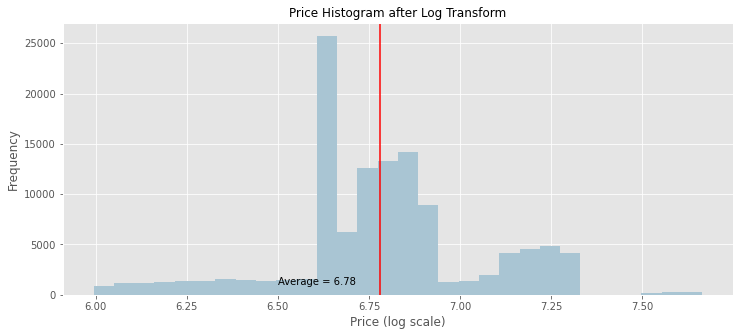

In [428]:
# Create the histogram for Age to observe the distribution
# Calculate the mean of Age_log for annotation in the histogram 
price_log_mean = np.round(np.mean(df1['price']), 2)

fig, ax = plt.subplots(figsize = (12,5))
df1['price'].hist(bins=30, color='#A9C5D3')
ax.axvline(price_log_mean, color='r', label = 'price_log_mean')
ax.set_title('Price Histogram after Log Transform', fontsize=12)
ax.set_xlabel('Price (log scale)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(6.5, 1000, f'Average = {price_log_mean}', fontsize=10)

The price feature looks more normally distributed after log transformation.

In [429]:
df1.head() 

,no_show,price,branch_Orchard,country_China,country_India,country_Indonesia,country_Japan,country_Malaysia,country_Singapore,first_time_Yes,...,platform_Website,num_adults_2,num_children_1,num_children_2,num_children_3,booking_month,arrival_month,arrival_day,checkout_month,checkout_day
0,1,6.630460,0,1,0,0,0,0,0,1,...,0,1,1,0,0,0.083643,0.098713,0.033885,0.100821,0.037031
1,0,6.914177,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0.080067,0.067459,0.033067,0.079814,0.034940
2,0,6.479953,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0.080067,0.098713,0.030149,0.100821,0.030757
3,0,6.887216,1,1,0,0,0,0,0,1,...,0,0,1,0,0,0.084275,0.087615,0.034012,0.086889,0.034940
4,0,6.630460,1,1,0,0,0,0,0,1,...,1,0,0,1,0,0.080421,0.067459,0.030630,0.064541,0.031102


In [430]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118576 entries, 0 to 118575
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   no_show               118576 non-null  int32  
 1   price                 118576 non-null  float64
 2   branch_Orchard        118576 non-null  int64  
 3   country_China         118576 non-null  int64  
 4   country_India         118576 non-null  int64  
 5   country_Indonesia     118576 non-null  int64  
 6   country_Japan         118576 non-null  int64  
 7   country_Malaysia      118576 non-null  int64  
 8   country_Singapore     118576 non-null  int64  
 9   first_time_Yes        118576 non-null  int64  
 10  room_President Suite  118576 non-null  int64  
 11  room_Queen            118576 non-null  int64  
 12  room_Single           118576 non-null  int64  
 13  platform_Email        118576 non-null  int64  
 14  platform_Phone        118576 non-null  int64  
 15  